In [2]:
import pandas as pd
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('train.csv')
df = df[:1000]

In [4]:
#Exploring the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1000 non-null   object
 1   comment_text   1000 non-null   object
 2   toxic          1000 non-null   int64 
 3   severe_toxic   1000 non-null   int64 
 4   obscene        1000 non-null   int64 
 5   threat         1000 non-null   int64 
 6   insult         1000 non-null   int64 
 7   identity_hate  1000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 62.6+ KB


In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
#Getting all the class names
classes = df.select_dtypes(include = ['int64']).columns.to_list()
classes

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [7]:
#Checking the ratio of data in each class
[df[col].value_counts(normalize = True) for col in classes]

[toxic
 0    0.895
 1    0.105
 Name: proportion, dtype: float64,
 severe_toxic
 0    0.991
 1    0.009
 Name: proportion, dtype: float64,
 obscene
 0    0.951
 1    0.049
 Name: proportion, dtype: float64,
 threat
 0    0.996
 1    0.004
 Name: proportion, dtype: float64,
 insult
 0    0.946
 1    0.054
 Name: proportion, dtype: float64,
 identity_hate
 0    0.991
 1    0.009
 Name: proportion, dtype: float64]

## Tokenizing The Text and Building Vocabulary

In [8]:
text = df['comment_text']

In [9]:
nlp = spacy.load('en_core_web_sm', enable=['tagger', 'morphologizer', 'attribute_ruler', 'lemmatizer'])
VOCAB_SIZE = 10000
def spacy_tokenizer(dataset):

    tokenized_dataset = []
    for doc in nlp.pipe(dataset):
        tokenized_dataset.append([token.lemma_.lower() for token in doc if 
                                  not token.is_punct and 
                                  not token.is_space and 
                                  not token.is_stop and 
                                  token.is_alpha])
    return tokenized_dataset

vocab = build_vocab_from_iterator(spacy_tokenizer(text), specials = ['<unk>','<pad>'], max_tokens = VOCAB_SIZE)
vocab.set_default_index(vocab['<unk>'])
                                  

## Creating Training and Test Dataset

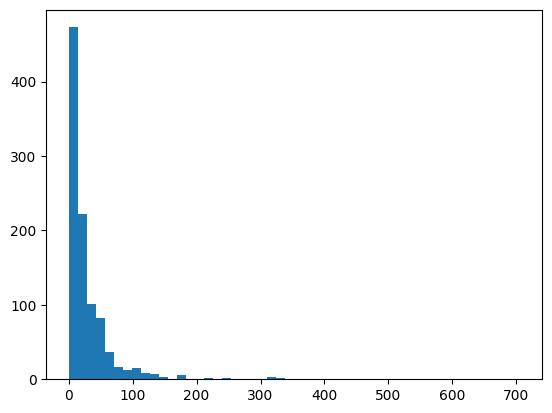

In [10]:
#Understanding the length of tokens in data
comment_tokens = spacy_tokenizer(text)
plt.hist(list(map(len, comment_tokens)), 50)
plt.show()

In [11]:
def pad_tokens(data, pad_token, max_length):
    if len(data)>=150:
        return data[:max_length]
    else:
        return data + [pad_token]*(max_length - len(data))


In [12]:
#Creating a class for pytorch dataset
class ToxicCommentDataset(Dataset):
    def __init__(self, data, max_length, is_test = False):
        self.data = data
        self.max_length = max_length
        self.is_test = is_test
        self.pad_token = '<pad>'
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = [self.data['comment_text'].values[index]]
        tokens = spacy_tokenizer(text)[0]
        output = torch.tensor(pad_tokens(vocab.lookup_indices(tokens),
                                         vocab[self.pad_token],
                                         self.max_length))
        if self.is_test:
            target = torch.tensor([0,0,0,0,0,0], dtype = torch.float)
        else :
            target = torch.tensor(self.data[classes].values[index], dtype = torch.float)
        return output, target
                                         
        

In [13]:
#Dividing the dataset into training and testing sets

MAX_LENGTH = 150
test_ratio = 0.25
train_dataset, test_dataset = train_test_split(df, test_size = test_ratio, shuffle = False)

train = ToxicCommentDataset(data = train_dataset, max_length = MAX_LENGTH, is_test = False)
test  = ToxicCommentDataset(data = test_dataset, max_length = MAX_LENGTH, is_test = True)

## Creating Pytorch Data Loaders

In [14]:
BATCH_SIZE = 64

train_loader = DataLoader(dataset = train, 
                          batch_size = BATCH_SIZE,
                          drop_last = True)
test_loader = DataLoader(dataset = test,
                         batch_size = BATCH_SIZE
                        )
len(train_loader),len(test_loader)

(11, 4)

In [15]:
input, target = next(iter(train_loader))
print(f'Training input shape: {input.shape}, target shape: {target.shape}')

Training input shape: torch.Size([64, 150]), target shape: torch.Size([64, 6])


## Building an LSTM Model

In [16]:
class ToxicCommentModel(nn.Module):
    def __init__(self, learning_rate = 1e-3):
        super().__init__()
        self.emb_layer = nn.Embedding(num_embeddings = VOCAB_SIZE,
                                      embedding_dim = 128,
                                      padding_idx = 1)
        self.bi_lstm = nn.LSTM(input_size = 128,
                               hidden_size = 64,
                               num_layers= 2,
                               batch_first = True,
                               bidirectional = True)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(64, 6)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.emb_layer(x)
        x, _ = self.bi_lstm(x)
        x = self.dropout1(x)
        x = self.relu(self.linear1(x)[:,-1,:])
        x = self.dropout2(x)
        return(self.linear2(x))

    def predict(self,x):
        pred_logits = self(x)
        pred_labels = torch.softmax(pred_logits, dim = 1)
        return pred_labels
        
        

## Create train & test loop functions

In [17]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    
    #Setup train loss
    train_loss = 0
    #loop through data laoder data batches
    for _, (X, y) in enumerate(dataloader):

        #forward pass
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        train_loss +=loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/len(dataloader)

def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module):
    model.eval()
    
    #setup test loss    
    test_loss = 0
    #loop through test dataloader batches
    for _,(X, y) in enumerate(dataloader):
        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        test_loss += loss

    #return test loss
    return test_loss

## Creating a train() function to combine train_step() and test_step()

In [18]:
def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):
    results = {'train_loss': [],
               'test_loss': []
              }

    #loop through training and test sets for the number of steps
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model, train_loader, loss_fn, optimizer)
        test_loss = test_step(model, test_loader, loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f}  "
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    # 6. Return the filled results at the end of the epochs
    return results
    

## Training and Evaluation

In [19]:
torch.manual_seed(42)

NUM_EPOCHS = 10
model = ToxicCommentModel()

loss_fn = F.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

model_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        loss_fn=loss_fn, 
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

 10%|████████▎                                                                          | 1/10 [00:05<00:49,  5.52s/it]

Epoch: 1 | train_loss: 0.3261 | test_loss: 0.0709  


 20%|████████████████▌                                                                  | 2/10 [00:14<01:02,  7.84s/it]

Epoch: 2 | train_loss: 0.1683 | test_loss: 0.1117  


 30%|████████████████████████▉                                                          | 3/10 [00:24<01:00,  8.58s/it]

Epoch: 3 | train_loss: 0.1523 | test_loss: 0.1499  


 40%|█████████████████████████████████▏                                                 | 4/10 [00:33<00:53,  8.85s/it]

Epoch: 4 | train_loss: 0.1536 | test_loss: 0.1410  


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:43<00:45,  9.07s/it]

Epoch: 5 | train_loss: 0.1530 | test_loss: 0.1380  


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:52<00:36,  9.17s/it]

Epoch: 6 | train_loss: 0.1562 | test_loss: 0.1485  


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:01<00:27,  9.12s/it]

Epoch: 7 | train_loss: 0.1465 | test_loss: 0.1331  


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:10<00:18,  9.04s/it]

Epoch: 8 | train_loss: 0.1511 | test_loss: 0.1368  


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:19<00:08,  8.98s/it]

Epoch: 9 | train_loss: 0.1518 | test_loss: 0.1353  


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.80s/it]

Epoch: 10 | train_loss: 0.1501 | test_loss: 0.1293  


## Plot the loss curves of Model

In [20]:
model_results.keys()

dict_keys(['train_loss', 'test_loss'])

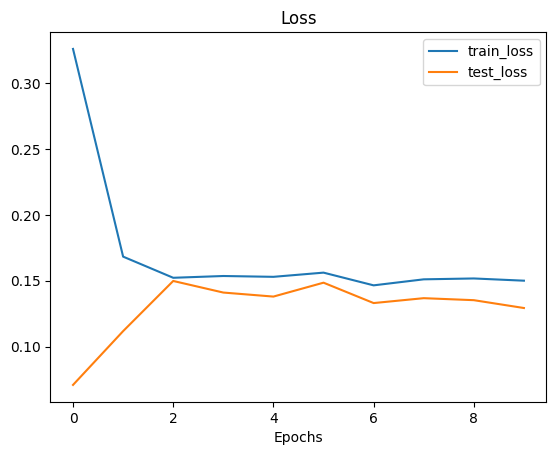

In [21]:
epochs = len(model_results['train_loss'])

# plt.figure(figsize = (15,7))

#Plot loss
plt.plot(range(epochs), model_results['train_loss'],label ='train_loss')
plt.plot(range(epochs), model_results['test_loss'], label = 'test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()
             